In [1]:
import os
os.chdir('/home/reffert/DeepAR_InfluenzaForecast')
from PythonFiles.model import model, preprocessing, split_forecasts_by_week, forecast_by_week, train_test_split
from PythonFiles.PlottingFunctions import plot_coverage, print_forecasts_by_week, hyperparameter_boxplots, plot_model_results_by_hp,\
hp_color_plot, plot_forecast_entry
from PythonFiles.Configuration import Configuration
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from PythonFiles.HpTuning import get_data
base_df = get_data(truncate=False, with_features=True)[1]
config = Configuration()
influenza_df = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/Notebooks/DataProcessing/influenza.csv", sep=',')
results_df = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/HyperparameterFiles/results.csv", sep=',')
locations = list(base_df.location.unique())

In [2]:
def process_R_results(config, results_df, influenza_df):
    '''
    Process the results_df by adding a date column and the corresponding true values.
    '''
    df = results_df.copy()
    # Split the values in the Time column saved as 822.1, 823.2,... as Time : 822, 823, ... and WeekAhead: 1, 2, ...
    df['Time'] = df['Time'].astype(str)
    df[['Time', 'WeekAhead']] = df['Time'].str.split('.', 1, expand=True)

    # Convert columns to appropriate types i.e., integer
    df['Time'] = df['Time'].astype(int)
    df['WeekAhead'] = df['WeekAhead'].astype(int)
    
    # The dates in the R representation of the influenza df are shifted by 1 position, example for SK München:
    # 821          0 2016-09-25
    # 822          0 2016-10-02
    # ...
    # 929          2 2018-10-21
    R_start = datetime(2016, 10, 2)
    R_end = datetime(2018, 10, 21)
    # determine the daterange of the forecast period
    daterange = pd.date_range(start=R_start, periods=len(results_df.Time.unique()),freq=config.parameters["freq"])
    influenza_df["date"] = pd.to_datetime(influenza_df["date"])
    # Iterate over the zipped pairs of time and date e.g., [(821,2016-09-25), ..., (929,2018-10-21)]  
    for i in zip(df.Time.unique(), daterange): 
        df.loc[df.Time == i[0], "date"] = i[1]
        
    df["date"] = pd.to_datetime(df["date"])
    # rename the location column so it matches with the influenza location columnname
    df.rename(columns = {'Location':'location'}, inplace = True)
    df = df.merge(influenza_df[["date", "value", "location"]], on = ["date", "location"]) 
    df.rename(columns = {'value':'true_value'}, inplace = True)
    return df

In [3]:
processed_df = process_R_results(config, results_df, influenza_df)
print(processed_df)

        Time  0.025  0.1  0.25  0.5  0.75  0.9  0.975             location  \
0        822      0    0     0    0     0    0      0         LK Ahrweiler   
1        823      0    0     0    0     0    0      1         LK Ahrweiler   
2        823      0    0     0    0     0    0      1         LK Ahrweiler   
3        824      0    0     0    0     0    0      1         LK Ahrweiler   
4        824      0    0     0    0     0    1      1         LK Ahrweiler   
...      ...    ...  ...   ...  ...   ...  ...    ...                  ...   
172615   927      0    0     0    0     0    0      1  StädteRegion Aachen   
172616   927      0    0     0    0     0    0      1  StädteRegion Aachen   
172617   928      0    0     0    0     0    1      1  StädteRegion Aachen   
172618   928      0    0     0    0     0    1      1  StädteRegion Aachen   
172619   929      0    0     0    0     0    1      2  StädteRegion Aachen   

        WeekAhead       date  true_value  
0               1 20

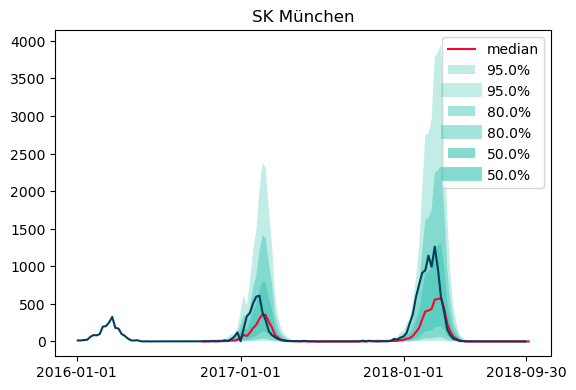

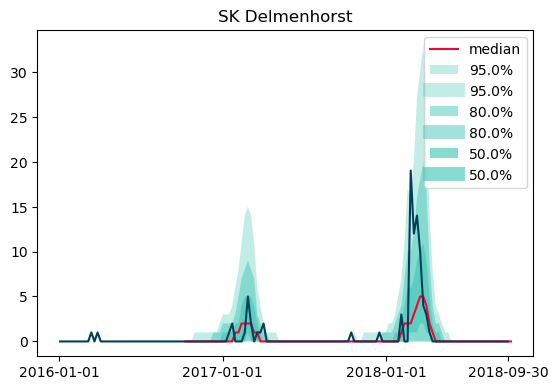

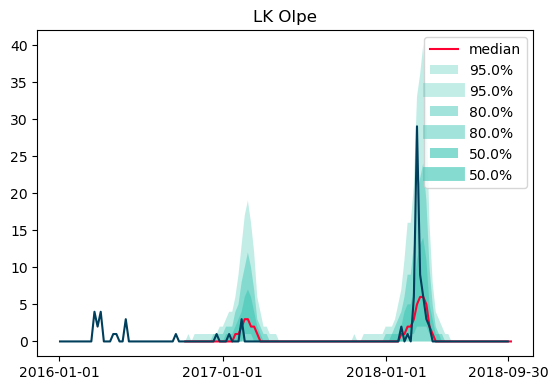

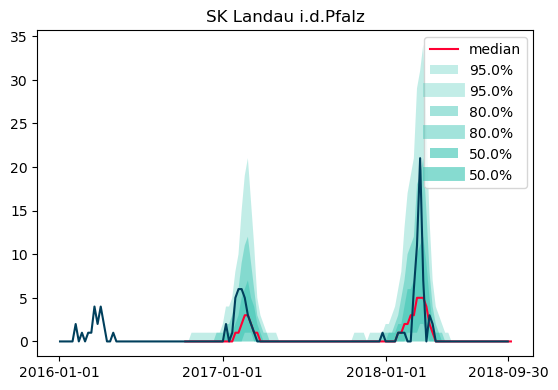

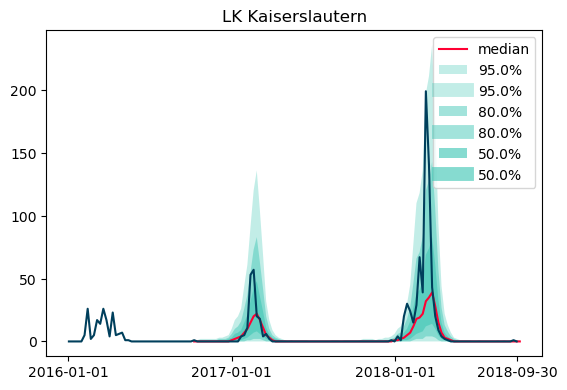

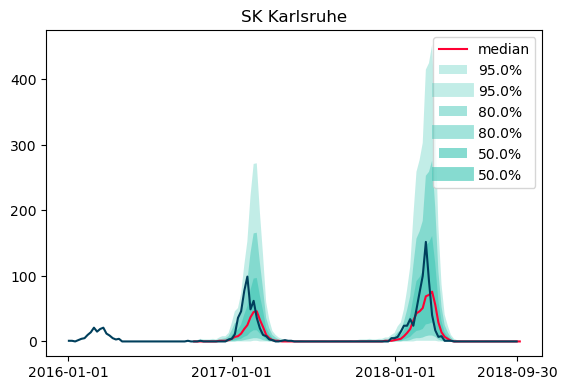

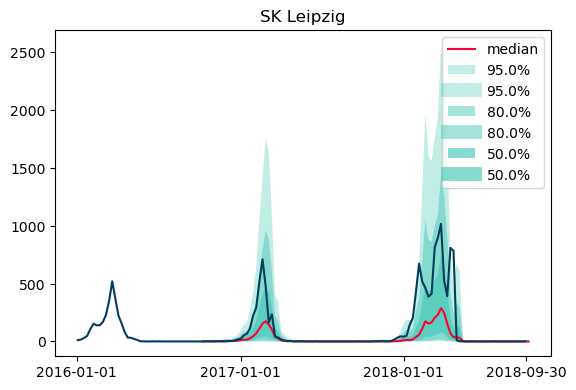

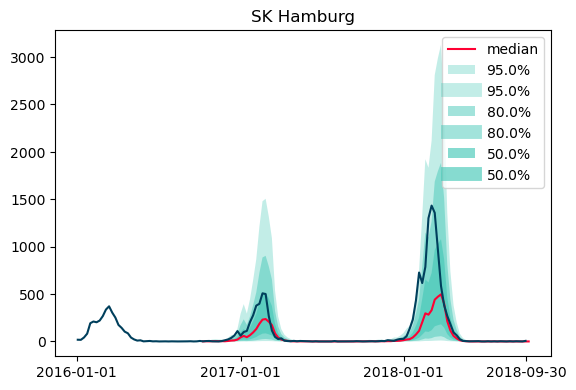

In [4]:
df_dict = {"hhh4":{1:processed_df[processed_df.WeekAhead == 1].copy(),
           2:processed_df[processed_df.WeekAhead == 2].copy(),
           3:processed_df[processed_df.WeekAhead == 3].copy(),
           4:processed_df[processed_df.WeekAhead == 4].copy()}}
df = df_dict["hhh4"][2]
selected_regions = ['SK München','SK Delmenhorst','LK Olpe', 'SK Landau i.d.Pfalz','LK Kaiserslautern','SK Karlsruhe', 'SK Leipzig','SK Hamburg']
for region in selected_regions:
    plot_forecast_entry(config, df.loc[df["location"]==region], show_mean=False,ax=plt, prediction_intervals=(50.0, 80.0, 95.0), meancolor=config.colors[1],\
                        mediancolor=config.colors[1], fillcolor=config.colors[2], R_entry=True) 
    filter_index = (influenza_df["location"]==region) & (influenza_df.date >=datetime(2016,1,1)) & (influenza_df.date <=config.test_end_time)
    plt.plot(influenza_df.loc[filter_index, "date"], influenza_df.loc[filter_index,"value"], c= config.colors[0])
    plt.xticks([datetime(2016,1,1), datetime(2017,1,1), datetime(2018,1,1), config.test_end_time], rotation=0, ha="center")
    plt.title(f"{region}")
    plt.legend()
    plt.show()

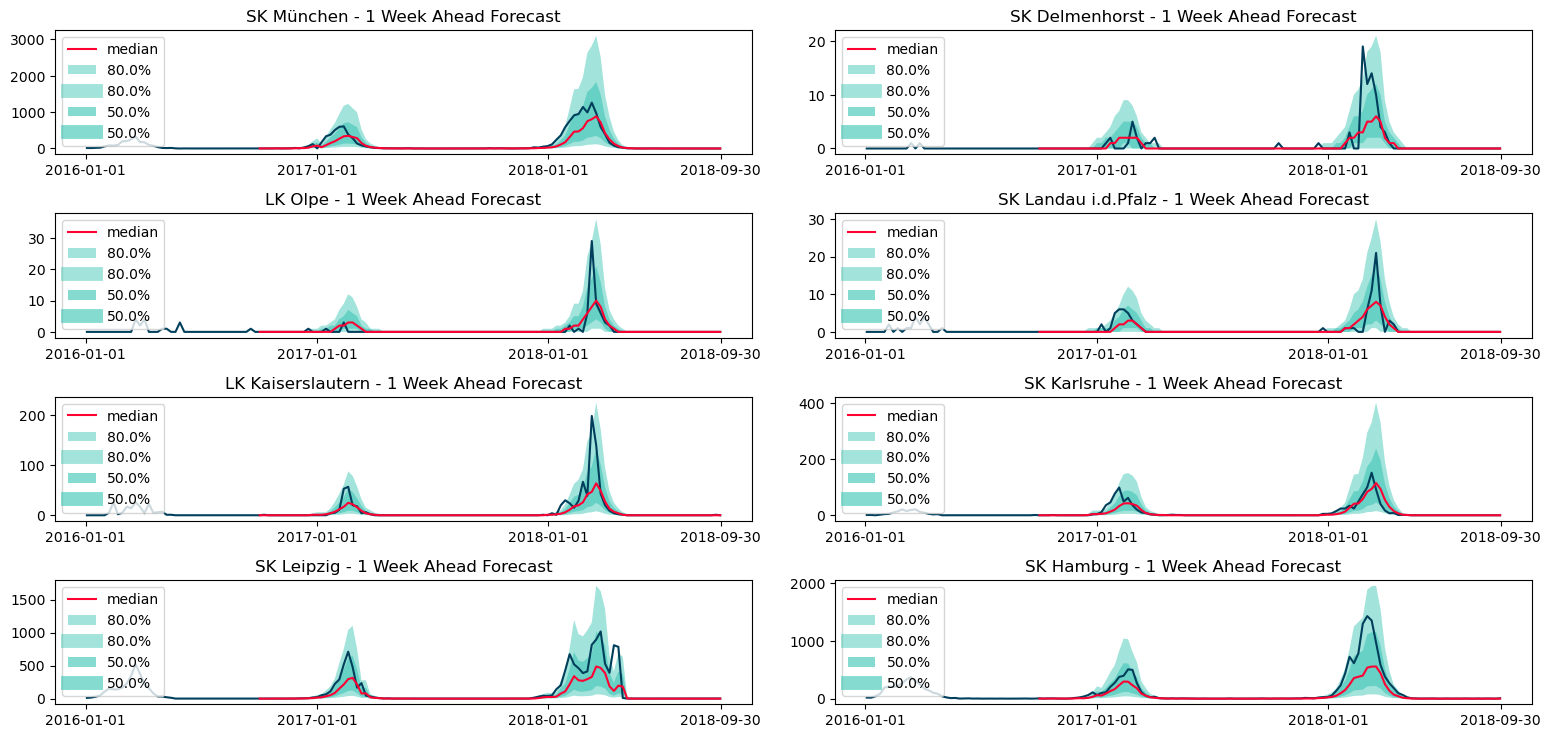

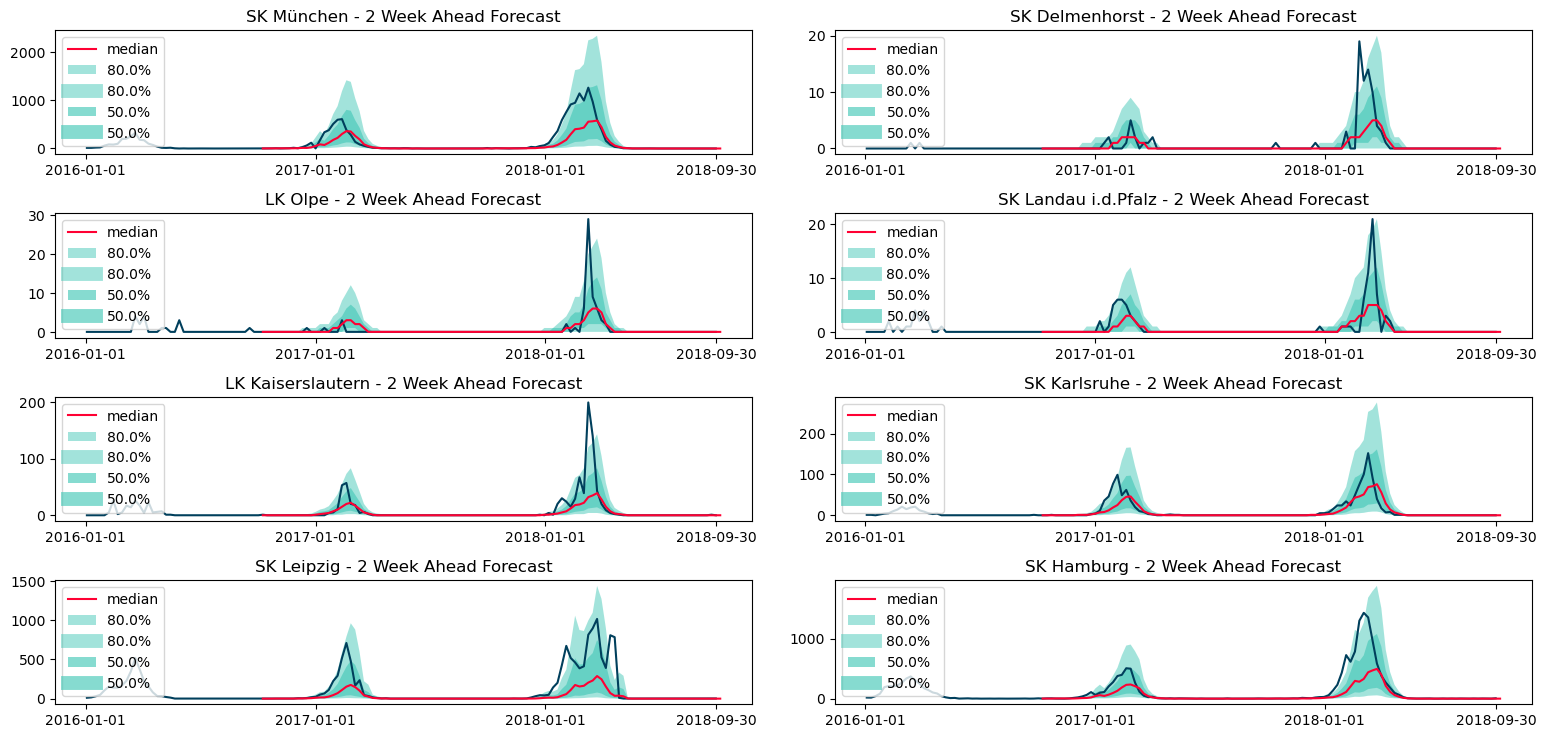

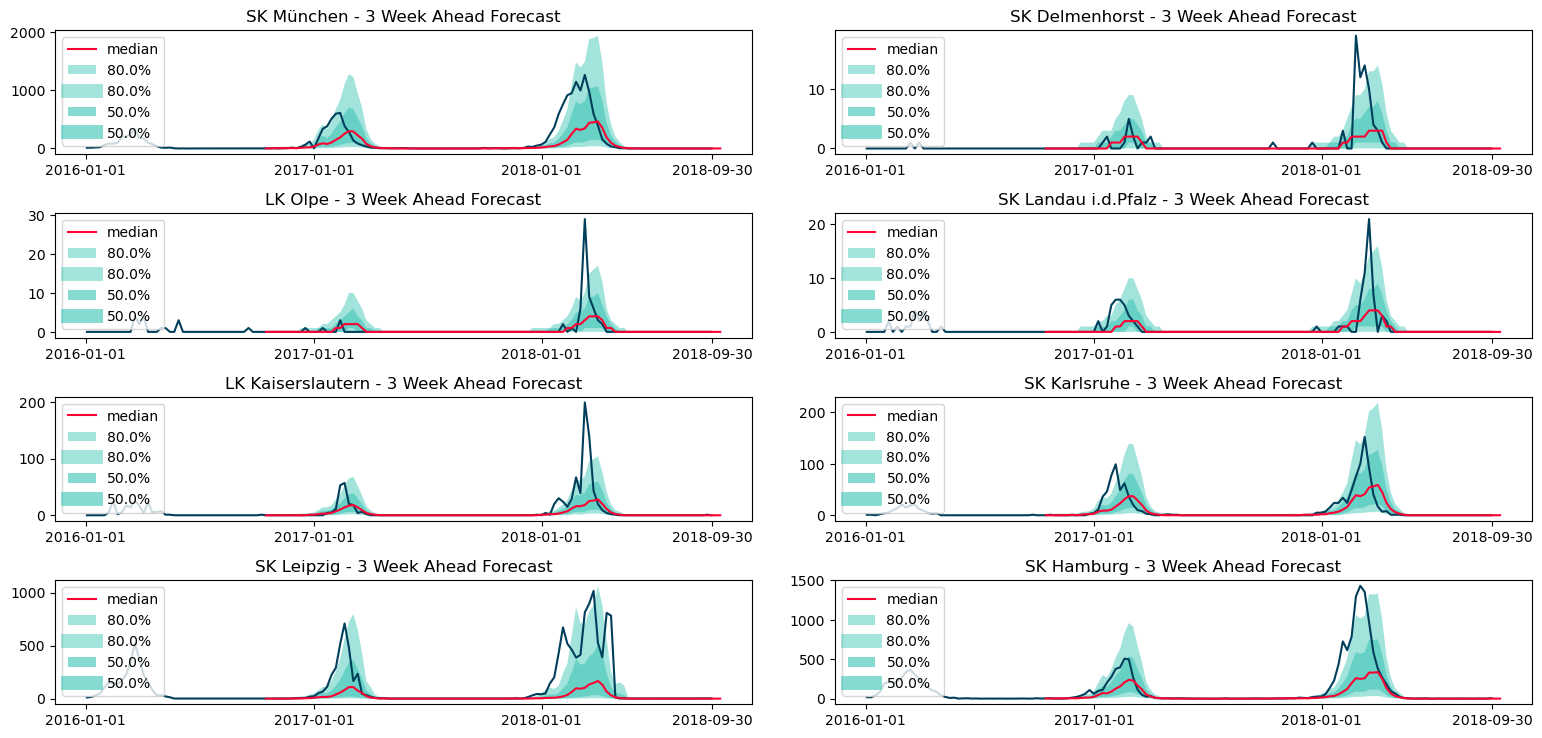

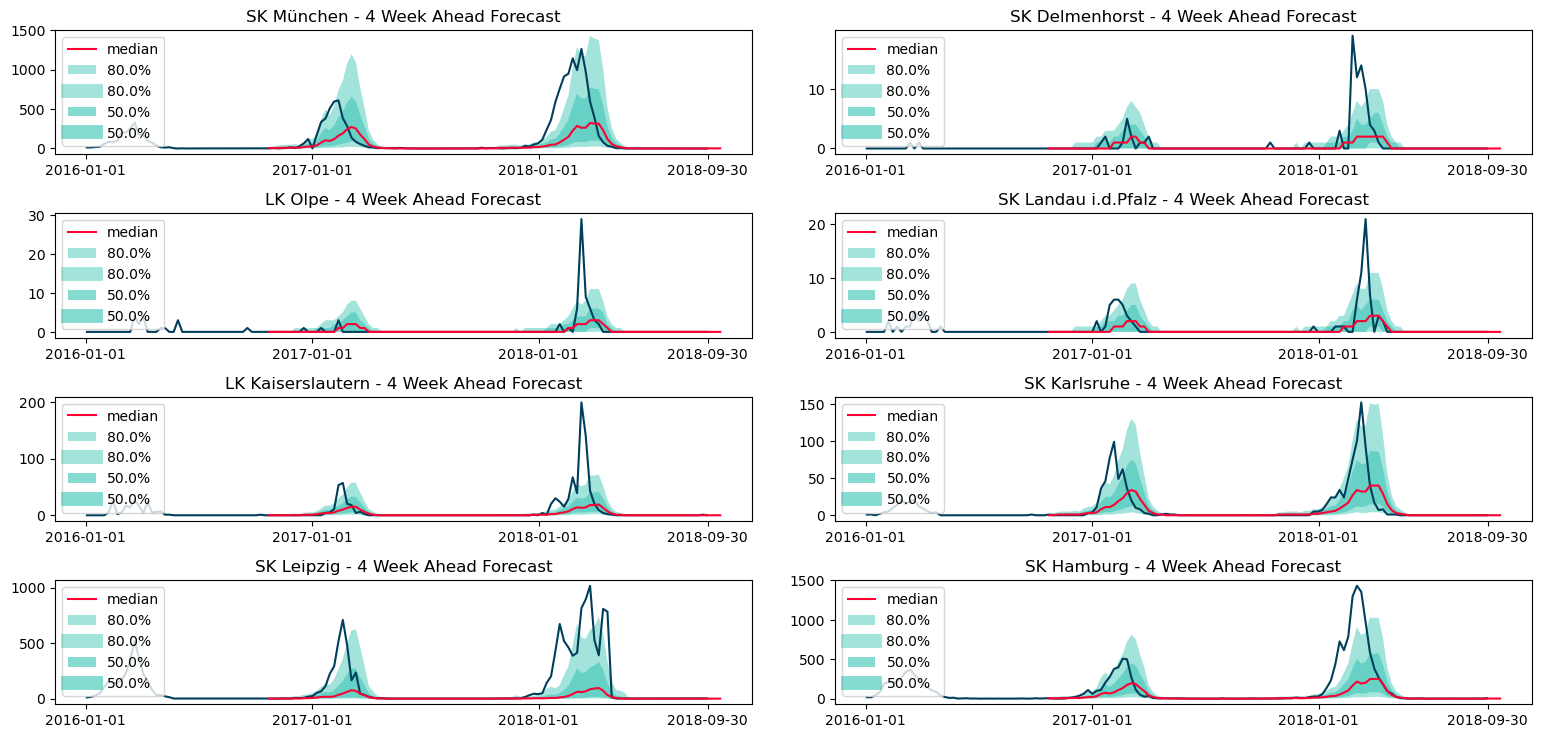

In [5]:
selected_regions = ['SK München','SK Delmenhorst','LK Olpe', 'SK Landau i.d.Pfalz','LK Kaiserslautern','SK Karlsruhe', 'SK Leipzig','SK Hamburg']

print_forecasts_by_week(config, base_df, df_dict, selected_regions[:], [1,2,3,4], plot_begin_at_trainstart=datetime(2016,1,1,0,0,0),\
                       savepath='/home/reffert/DeepAR_InfluenzaForecast/Notebooks/FigureCreation', filename="")

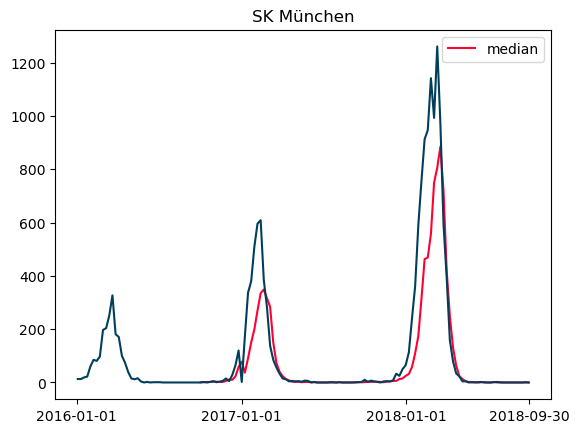

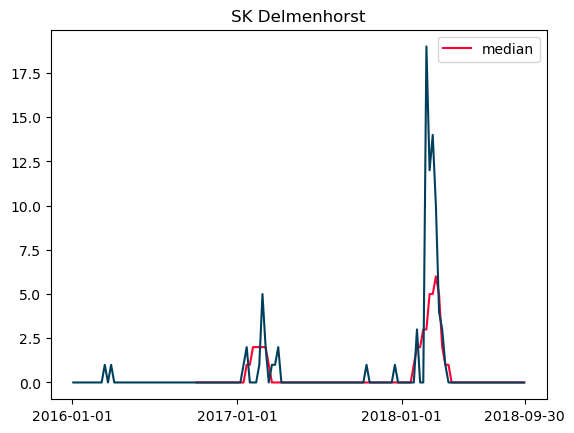

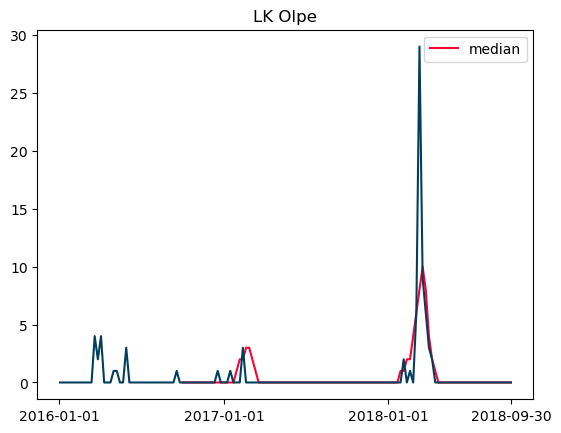

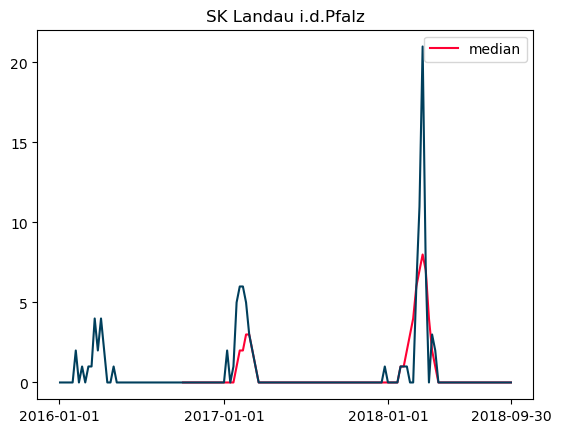

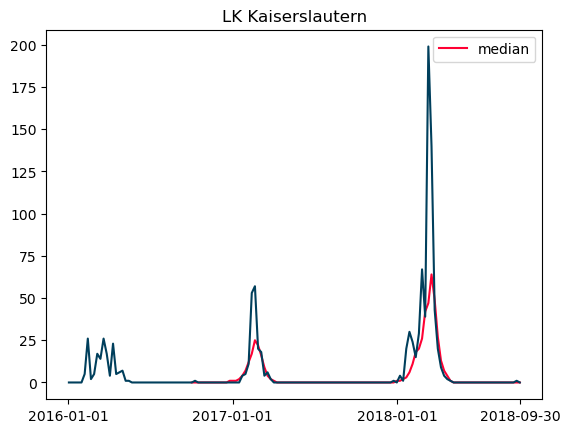

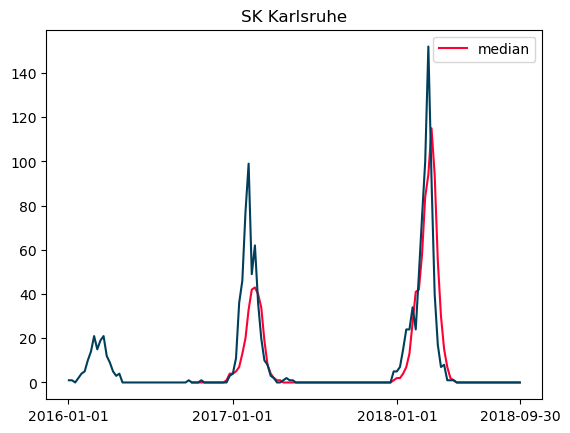

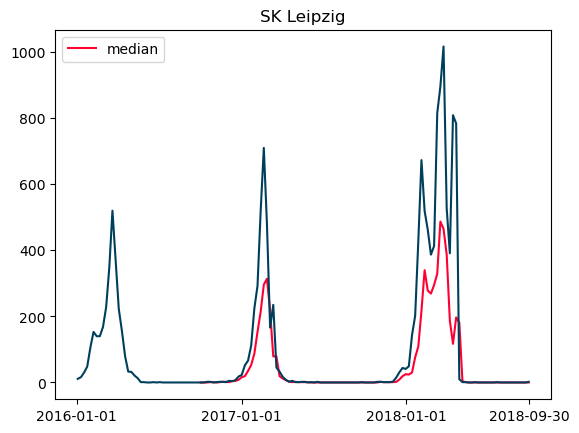

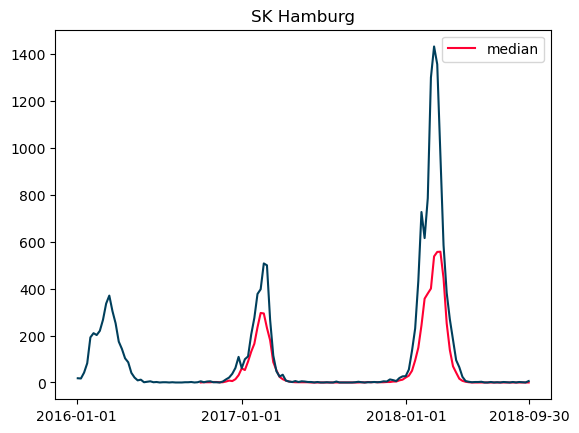

In [6]:
df_dict = {"1":processed_df[processed_df.WeekAhead == 1].copy(),
           "2":processed_df[processed_df.WeekAhead == 2].copy(),
           "3":processed_df[processed_df.WeekAhead == 3].copy(),
           "4":processed_df[processed_df.WeekAhead == 4].copy()}
df = df_dict["1"]
selected_regions = ['SK München','SK Delmenhorst','LK Olpe', 'SK Landau i.d.Pfalz','LK Kaiserslautern','SK Karlsruhe', 'SK Leipzig','SK Hamburg']
for region in selected_regions:
    i=2
    for quantile in config.quantiles:
        #plt.plot(df.loc[df["location"]==region,"date"], df.loc[df["location"]==region,f"{quantile}"], c=config.colors[i], label=f"{quantile}")
        i +=1
    plt.plot(df.loc[df["location"]==region,"date"], df.loc[df["location"]==region,f"0.5"], c=config.colors[1], label=f"median")
    filter_index = (influenza_df["location"]==region) & (influenza_df.date >=datetime(2016,1,1)) & (influenza_df.date <=config.test_end_time)
    plt.plot(influenza_df.loc[filter_index, "date"], influenza_df.loc[filter_index,"value"], c= config.colors[0])
    plt.xticks([datetime(2016,1,1), datetime(2017,1,1), datetime(2018,1,1), config.test_end_time], rotation=0, ha="center")
    plt.title(f"{region}")
    plt.legend()
    plt.show()

In [7]:
def evaluate(config, df_dict, locations):
    def quantile_loss(target: np.ndarray, forecast: np.ndarray, q: float) -> float:
        r"""
        .. math::

            quantile\_loss = 2 * sum(|(Y - \hat{Y}) * (Y <= \hat{Y}) - q|)
        """
        return 2 * np.sum(np.abs((forecast - target) * ((target <= forecast) - q)))

    def coverage(target: np.ndarray, forecast: np.ndarray) -> float:
        r"""
        .. math::

            coverage = mean(Y <= \hat{Y})
        """
        return np.mean(target <= forecast)

    def abs_target_sum(target) -> float:
        r"""
        .. math::

            abs\_target\_sum = sum(|Y|)
        """
        return np.sum(np.abs(target))
    
    evaluator_df = pd.DataFrame({"item_id":["aggregated {" + f"{week}" + "}" for week in [1, 2, 3, 4]]+[f"{location} "+ "{" + f"{week}" + "}" for location in locations for week in [1,2,3,4]]})
    # determine the metrics for individual series
    for week_ahead in [1, 2, 3, 4]:
        df = df_dict[f"{week_ahead}"].copy()
        for quantile in config.quantiles:
            for location in locations:
                # calculate the Quantile Loss and the Coverage for each region
                evaluator_df.loc[evaluator_df.item_id == str(f"{location} "+ "{" + f"{week_ahead}" + "}"),f"QuantileLoss[{quantile}]"] =\
                    quantile_loss(df.loc[df["location"]==location, "true_value"], df.loc[df["location"]==location, f"{quantile}"], quantile)
                
                evaluator_df.loc[evaluator_df.item_id == str(f"{location} "+ "{" + f"{week_ahead}" + "}"),f"Coverage[{quantile}]"] =\
                    coverage(df.loc[df["location"]==location, "true_value"], df.loc[df["location"]==location, f"{quantile}"])

            evaluator_df.loc[evaluator_df.item_id == str("aggregated {" + f"{week_ahead}" + "}"),f"QuantileLoss[{quantile}]"] =\
                quantile_loss(df["true_value"], df[f"{quantile}"], quantile)
            
            evaluator_df.loc[evaluator_df.item_id == str("aggregated {" + f"{week_ahead}" + "}"),f"Coverage[{quantile}]"] =\
                coverage(df["true_value"], df[f"{quantile}"])
            
    # add the aggregate metrics
    evaluator_df["abs_target_sum"] = abs_target_sum(processed_df["true_value"])
    #for week_ahead in [1,2,3,4]:
    for quantile in config.quantiles:
        evaluator_df[f"wQuantileLoss[{quantile}]"] = (evaluator_df[f"QuantileLoss[{quantile}]"] / evaluator_df["abs_target_sum"])
    for item_id in evaluator_df.item_id.unique():   
        df = evaluator_df[evaluator_df.item_id == item_id].copy()
        df["mean_absolute_QuantileLoss"] = np.array([df[f"QuantileLoss[{quantile}]"] for quantile in config.quantiles]).mean()
        df["mean_wQuantileLoss"] = np.array([df[f"wQuantileLoss[{quantile}]"]for quantile in config.quantiles]).mean()
        df["MAE_Coverage"] = np.mean([np.abs(df[f"Coverage[{quantile}]"] - np.array([q]))for q in config.quantiles])    
        evaluator_df.loc[evaluator_df.item_id == item_id, ["mean_absolute_QuantileLoss", "mean_wQuantileLoss", "MAE_Coverage"]] = df[["mean_absolute_QuantileLoss", "mean_wQuantileLoss", "MAE_Coverage"]]
    # produce the average Quantile Loss metric by dividing the mean absolute QL through the number of involved locations per weekahead, which is usually 411 (each district)
    included_locations = [item_id for item_id in evaluator_df.item_id.unique() if "aggregated" not in item_id if "1" in item_id]
    evaluator_df.loc[evaluator_df.item_id.isin([item_id for item_id in evaluator_df.item_id if "aggregate" in item_id]), "mean_WIS"] = evaluator_df.loc[evaluator_df.item_id.isin([item_id for item_id in evaluator_df.item_id if "aggregate" in item_id]),"mean_absolute_QuantileLoss"]/len(included_locations)        
    return evaluator_df

df_dict = {"1":processed_df[processed_df.WeekAhead == 1].copy(),
           "2":processed_df[processed_df.WeekAhead == 2].copy(),
           "3":processed_df[processed_df.WeekAhead == 3].copy(),
           "4":processed_df[processed_df.WeekAhead == 4].copy()}
locations = list(influenza_df.location.unique())
evaluator_df = evaluate(config, df_dict, locations)

In [8]:
#print(evaluator_df[evaluator_df["mean_WIS"]!=0])
#print(evaluator_df[[col for col in evaluator_df.columns if "Coverage" in col]])
print(evaluator_df[[col for col in evaluator_df.columns if "Quantile" in col]])
#print(evaluator_df["mean_WIS"])

      QuantileLoss[0.025]  QuantileLoss[0.1]  QuantileLoss[0.25]  \
0                23336.85            88260.6            189051.5   
1                23480.30            90770.0            204350.5   
2                23516.50            91952.4            214249.5   
3                23530.20            92779.6            221322.0   
4                   28.30              107.4               228.5   
...                   ...                ...                 ...   
1643                15.85               63.4               152.0   
1644                50.75              193.8               420.0   
1645                50.95              198.4               446.5   
1646                50.95              200.2               464.0   
1647                50.95              201.4               479.0   

      QuantileLoss[0.5]  QuantileLoss[0.75]  QuantileLoss[0.9]  \
0              260844.0            217098.5           143437.6   
1              318520.0            303728.0        

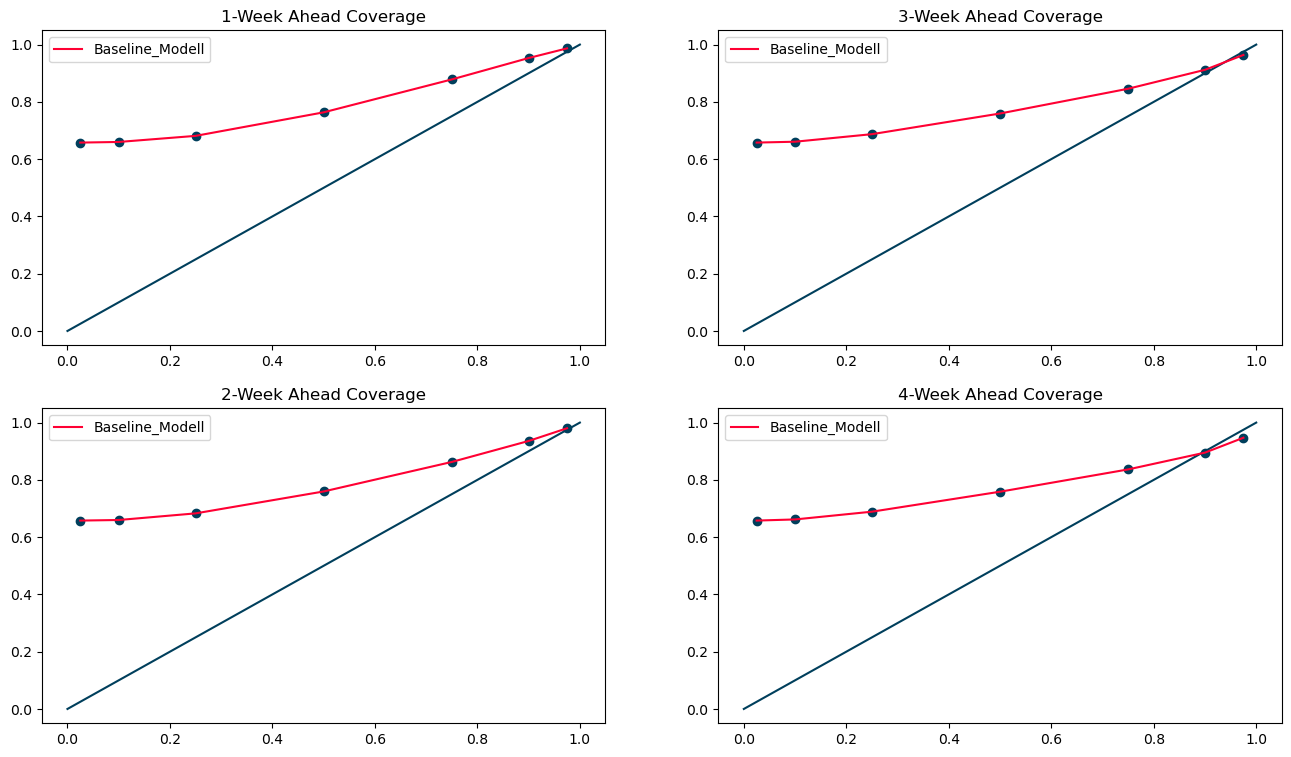

In [9]:
eval_dict = {"Baseline_Modell": evaluator_df}
plot_coverage(config, eval_dict, locations=None)